In [1]:
import Trainer_RNN_finance as Trainer
data_params={
    "ticker":'BTC-USD',
    "interval":'1m',
    "num_days":3,
    "seq_length":60,
    "predict_length":1,
    "target_column": 'Close'}

model_params = {
    "features":['Open', 'High', 'Low', 'Volume', 'Close'],
    "input_size":5,
    "hidden_size":50,
    "num_layers":2,
    "output_size":1
    }


train_params ={"lr":0.001,
               "num_epochs":100}

T1=Trainer.RNN_timeseries_forecast(data_params, train_params, model_params)

In [2]:
X_train,Y_train, X_test,Y_test, scaler_X, scaler_Y = T1.prepare_data()
model, train_loss, test_loss = T1.fit(X_train,Y_train, X_test,Y_test)


[*********************100%%**********************]  1 of 1 completed
c:\Users\phili\OneDrive\Projekte\Code\GitHub\timeseries_forcast_in_finance_MLops\Trainer_RNN_finance.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.columns]= scaler_X.transform(df[df.columns])


Epoch [10/100], Loss: 0.0810
Epoch [20/100], Loss: 0.0255
Epoch [30/100], Loss: 0.0017
Epoch [40/100], Loss: 0.0018
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0003
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0002
Test Loss: 0.0003


In [3]:
import pickle
pickle.dump(model, open('model.pkl','wb'))
pickle.dump(scaler_X, open('scaler_X.pkl','wb'))
pickle.dump(scaler_Y, open('scaler_Y.pkl','wb'))
predictions=[]

In [4]:
import yfinance as yf
import torch
import pandas as pd
import pickle
import datetime as dt
ticker='BTC-USD'
stock = yf.Ticker(ticker)
data = stock.history(period="1d", interval="1m")

data=data.tail(60)
data.shape
features = data[['Open', 'High', 'Low', 'Volume', 'Close']]
features[features.columns]= scaler_X.transform(features[features.columns])
features = features.values
features = torch.tensor(features, dtype=torch.float32)
features =features.unsqueeze(0)

        # Load pre-trained model
model = pickle.load(open('model.pkl','rb')) # Replace with your model's path
scaler_X =pickle.load(open('scaler_X.pkl','rb'))
scaler_Y =pickle.load(open('scaler_Y.pkl','rb'))

model.eval()
new_predictions = model(features)
predicetd_price =  scaler_Y.inverse_transform(new_predictions.detach().numpy() )
current_time = data.index[-1]
print(current_time)
predict_time =current_time + dt.timedelta(minutes=1)
        # Append new predictions to the global list
    
predictions.append({'Datetime': predict_time,'Prediction': predicetd_price.item() })
df = pd.DataFrame.from_dict(predictions)
df_target = data['Close'].reset_index()

#print(df_target.tail())
#print(df.tail())

df_final= pd.concat([df, df_target],keys=['Datetime','Close','Prediction'])

#df_final = df_final.sort_values(by='Datetime').reset_index(drop=True)
print(df_final)
#df_final_drop =df_final.dropna().reset_index()
#df_final_drop

2024-07-21 18:21:00+00:00
                             Datetime    Prediction         Close
Datetime 0  2024-07-21 18:22:00+00:00  66341.414062           NaN
Close    0  2024-07-21 17:20:00+00:00           NaN  67401.601562
         1  2024-07-21 17:21:00+00:00           NaN  67398.507812
         2  2024-07-21 17:22:00+00:00           NaN  67423.851562
         3  2024-07-21 17:23:00+00:00           NaN  67422.460938
...                               ...           ...           ...
         55 2024-07-21 18:16:00+00:00           NaN  66364.117188
         56 2024-07-21 18:17:00+00:00           NaN  66479.078125
         57 2024-07-21 18:18:00+00:00           NaN  66451.320312
         58 2024-07-21 18:20:00+00:00           NaN  66493.437500
         59 2024-07-21 18:21:00+00:00           NaN  66493.468750

[61 rows x 3 columns]


C:\Users\phili\AppData\Local\Temp\ipykernel_10228\863300586.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[features.columns]= scaler_X.transform(features[features.columns])


In [5]:
import matplotlib
import matplotlib.pyplot as plt
def plot_predictions(plot_data):

    fig, ax = plt.subplots()

    ax.plot(plot_data['Datetime'], plot_data['Close'], label='Actual', color='blue')
    ax.plot(plot_data['Datetime'], plot_data['Prediction'], label='Prediction', color='orange')

    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Stock Price Prediction')
    plt.legend()
    plt.grid(True)



In [ ]:

import os
def load_latest_model_and_scalers(ticker: str):
   
    base_directory = f"./models/{ticker}"
        
        
    # Find the latest model directory
    if not os.path.exists(base_directory) :
        raise FileNotFoundError(f"No models directory found for ticker {ticker}")

    model_files = sorted(
        [f for f in os.listdir(base_directory ) if f.endswith('.pkl')],
        key=lambda x: os.path.getmtime(os.path.join(base_directory , x))
        )
        
    if not model_files:
        raise FileNotFoundError(f"No model files found in {base_directory}")
        
    latest_model_file = model_files[-1]  # Get the latest model file
    model_path = os.path.join(base_directory , latest_model_file)
        
    # Load the model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        
    # Load the scalers
    scaler_X_path = os.path.join(base_directory , 'scaler_X.pkl')
    scaler_Y_path = os.path.join(base_directory , 'scaler_Y.pkl')
        
    if not os.path.exists(scaler_X_path) or not os.path.exists(scaler_Y_path):
        raise FileNotFoundError("Scaler files not found for the latest model.")
        
    with open(scaler_X_path, 'rb') as f:
        scaler_X = pickle.load(f)
        
    with open(scaler_Y_path, 'rb') as f:
        scaler_Y = pickle.load(f)

    return model, scaler_X, scaler_Y
    



In [1]:
import plotting_Class
import yaml
import os 

with open('train_params.yaml', 'r') as file:
    params = yaml.safe_load(file)
        
    data_params = params['data_params']
    data_params['ticker'] = 'BTC-USD'
    model_params = params['model_params']
    train_params = params['train_params']

path ='models/BTC-USD'
entries = os.listdir(path)
        
# Filter out files, only keep directories
model_names = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
model_names
P = plotting_Class.create_plot(data_params, model_names)
model, train_loss, test_loss = P.train_model()
#ticker = 'BTC-USD'


AttributeError: 'create_plot' object has no attribute 'train_model'

In [2]:
import RNN_model_class
import helper_fct

data_params={
    "ticker":'BTC-USD',
    "interval":'1m',
    "num_days":3,
    "seq_length":60,
    "predict_length":1,
    "target_column": 'Close'}

model_params = {
    "features":['Open', 'High', 'Low', 'Volume', 'Close'],
    "input_size":5,
    "hidden_size":50,
    "num_layers":2,
    "output_size":1,
    "model_name": 'RNN_21.07.2024__23.58'}


train_params ={"lr":0.001,
               "num_epochs":100}

params = {}
params['data_params'] = data_params
params['model_params'] = model_params
params['train_params'] = train_params

model = None
scaler_X = None
scaler_Y = None

#RNN_model = RNN_model_class.RNN_model(params, model, scaler_X, scaler_Y)
#model, scaler_X, scaler_Y, train_loss, test_loss = RNN_model.train_model()

Columns in data: Index(['Datetime', 'Close'], dtype='object')
                     Datetime         Close
764 2024-07-22 13:11:00+00:00  67842.750000
765 2024-07-22 13:12:00+00:00  67823.890625
766 2024-07-22 13:13:00+00:00  67817.210938
767 2024-07-22 13:14:00+00:00  67802.210938
768 2024-07-22 13:15:00+00:00  67749.125000
769 2024-07-22 13:16:00+00:00  67651.617188
770 2024-07-22 13:17:00+00:00  67630.632812
771 2024-07-22 13:18:00+00:00  67649.937500
772 2024-07-22 13:20:00+00:00  67644.203125
773 2024-07-22 13:21:00+00:00  67703.859375
774 2024-07-22 13:22:00+00:00  67673.468750
775 2024-07-22 13:23:00+00:00  67671.781250
776 2024-07-22 13:24:00+00:00  67678.695312
777 2024-07-22 13:25:00+00:00  67661.625000
778 2024-07-22 13:26:00+00:00  67672.523438
779 2024-07-22 13:27:00+00:00  67650.750000
780 2024-07-22 13:28:00+00:00  67631.820312
781 2024-07-22 13:29:00+00:00  67626.367188
782 2024-07-22 13:31:00+00:00  67550.187500
783 2024-07-22 13:32:00+00:00  67589.171875
784 2024-07-22

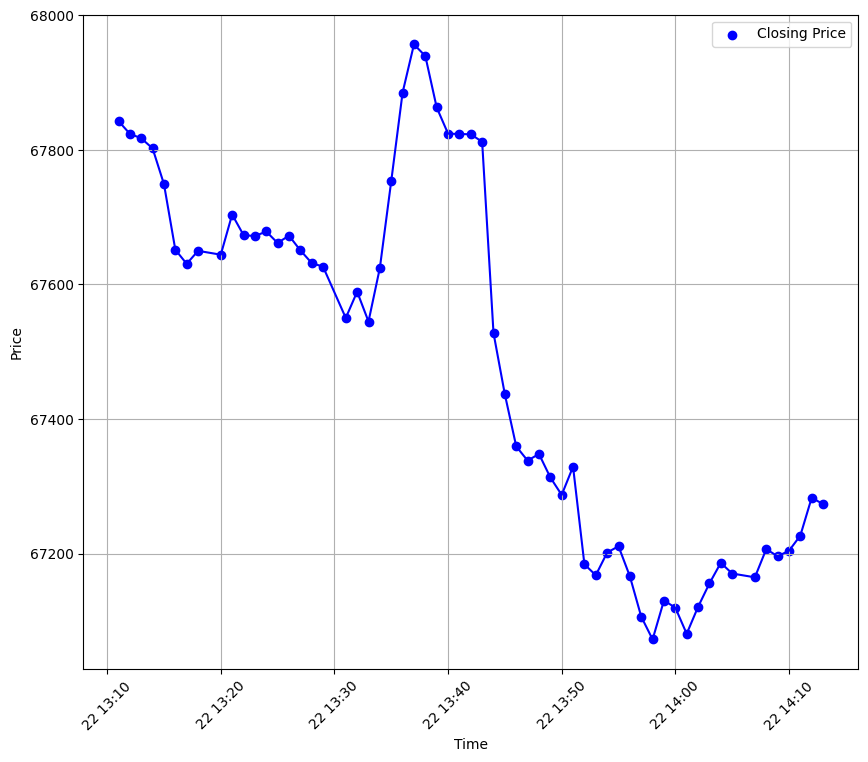

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
def fetch_stock_data(ticker: str, period: str, interval: str):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval) 
    return data

def plot_predictions(plot_data, model_names):
    print(plot_data)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8.5)
    ax.scatter(plot_data['Datetime'], plot_data['Close'], label='Closing Price', color='blue')
    ax.plot(plot_data['Datetime'], plot_data['Close'], color='blue')

    for name in model_names:
        ax.scatter(plot_data['Datetime'], plot_data[name], label=name)
        ax.plot(plot_data['Datetime'], plot_data[name])

    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
period = '1d'
interval = '1m'
ticker = 'BTC-USD'
# load the stock data
data = fetch_stock_data(ticker, period, interval)
data= data['Close'].reset_index()
data = data.tail(60)
print("Columns in data:", data.columns)
buf = plot_predictions(data, [])

In [21]:
import RNN_model_class
import helper_fct
import pandas as pd




model_names = ['RNN_21.07.2024__23.58', 'RNN_22.07.2024__11.20']
ticker  = 'BTC-USD'
data = helper_fct.get_predict_data( ticker = params['data_params']['ticker'],
                                        interval = params['data_params']['interval'],
                                        seq_length =params['data_params']['seq_length'] )
    
# Load and prepare the data
plot_data = data['Close'].reset_index()

plot_data['Datetime'] = pd.to_datetime(plot_data['Datetime'])


all_preds={}

In [ ]:
    
for name in model_names:

    params, model, scaler_X, scaler_Y = helper_fct.load_model(ticker,name)
    model = RNN_model_class.RNN_model( params = params,
                                             model= model,
                                             scaler_X= scaler_X,
                                             scaler_Y= scaler_Y )

    prediction = model.predict(ticker, data)
    
    df = pd.DataFrame({'Datetime': prediction['Datetime'], name:  prediction['Value']})
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    plot_data = pd.merge(plot_data, df, on="Datetime", how='outer')


plot_data


In [45]:
import pandas as pd
df = pd.DataFrame()
model_names = ['RNN_21.07.2024__23.58', 'RNN_22.07.2024__11.20']
ticker  = 'BTC-USD'
data = helper_fct.get_predict_data( ticker = params['data_params']['ticker'],
                                        interval = params['data_params']['interval'],
                                        seq_length =params['data_params']['seq_length'] )
    
# Load and prepare the data
plot_data = data['Close'].reset_index()
plot_data['Datetime'] = pd.to_datetime(plot_data['Datetime'])

for name in model_names:
        if all_preds=={}:
            all_preds ={'Datetime' : [],'Prediction': [],'Model_name' : []}

        params, model, scaler_X, scaler_Y = helper_fct.load_model(ticker,name)
        model = RNN_model_class.RNN_model( params = params,
                                                    model= model,
                                                    scaler_X= scaler_X,
                                                    scaler_Y= scaler_Y )

        prediction = model.predict(ticker, data)
        all_preds['Datetime'].append(prediction['Datetime'])
        all_preds['Prediction'].append(prediction['Prediction'])
        all_preds['Model_name'].append(name)

df = pd.DataFrame(all_preds)
df = df.drop_duplicates(subset=['Datetime', 'Model_name'])

# refactor df so that it has the structure:
# Datetime      Model_name_A            Model_name_B
# date          prediction_model A      prediction_model B                       
pivoted_df = df.pivot(index='Datetime', columns='Model_name', values='Prediction').reset_index()
df_final = pd.merge(pivoted_df, plot_data, on="Datetime", how='outer').sort_values(by='Datetime').reset_index(drop=True)


print(df_final)

                    Datetime  RNN_21.07.2024__23.58  RNN_22.07.2024__11.20  \
0  2024-07-22 11:07:00+00:00                    NaN                    NaN   
1  2024-07-22 11:08:00+00:00                    NaN                    NaN   
2  2024-07-22 11:09:00+00:00                    NaN                    NaN   
3  2024-07-22 11:10:00+00:00                    NaN                    NaN   
4  2024-07-22 11:11:00+00:00                    NaN                    NaN   
..                       ...                    ...                    ...   
57 2024-07-22 12:05:00+00:00                    NaN                    NaN   
58 2024-07-22 12:07:00+00:00                    NaN                    NaN   
59 2024-07-22 12:08:00+00:00                    NaN                    NaN   
60 2024-07-22 12:09:00+00:00                    NaN                    NaN   
61 2024-07-22 12:10:00+00:00           66137.296875           66860.148438   

           Close  
0   67389.382812  
1   67388.796875  
2   67

c:\Users\phili\OneDrive\Projekte\Code\GitHub\timeseries_forcast_in_finance_MLops\RNN_model_class.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[features.columns] = self.scaler_X.transform(features[features.columns])
c:\Users\phili\OneDrive\Projekte\Code\GitHub\timeseries_forcast_in_finance_MLops\RNN_model_class.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[features.columns] = self.scaler_X.transform(features[features.columns])


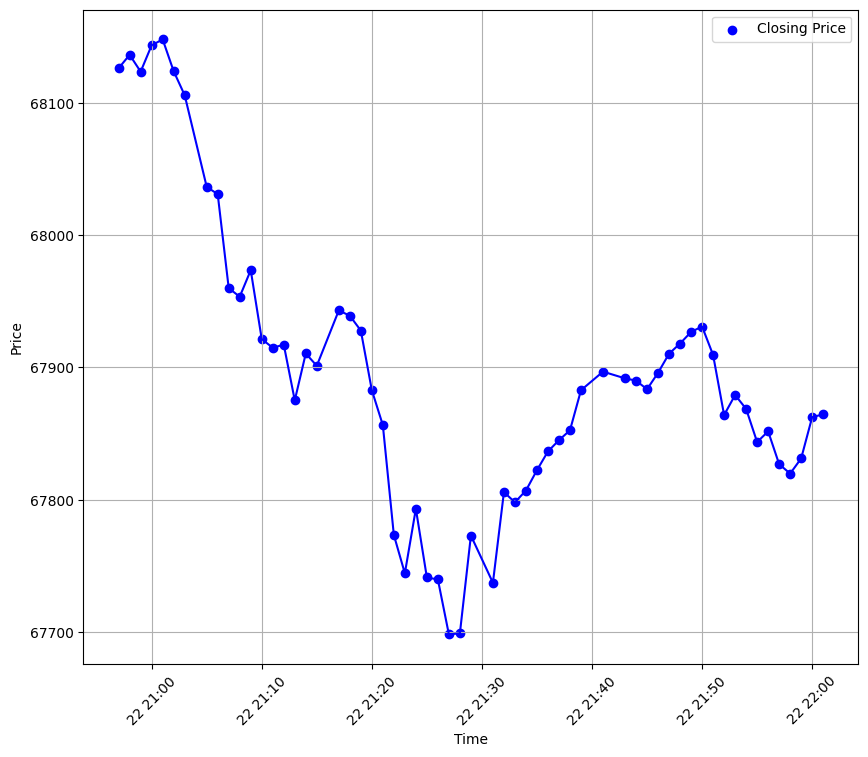

In [11]:
import helper_fct
import pandas as pd
ticker = 'BTC-USD'
modelNames = []
all_preds={}

# load prediction data 
data = helper_fct.get_predict_data(ticker=ticker, interval='1m', seq_length=60)

plot_data = data['Close'].reset_index()
plot_data['Datetime'] = pd.to_datetime(plot_data['Datetime'])

# Iitialize all_preds if empty
if all_preds =={}:
    all_preds = {'Datetime': [], 'Prediction': [], 'Model_name': []}

for name in modelNames :
    params, model, scaler_X, scaler_Y = helper_fct.load_model(ticker, name)
    model = RNN_model_class.RNN_model(params=params, model=model, scaler_X=scaler_X, scaler_Y=scaler_Y)
    prediction = model.predict(ticker, data)
    all_preds['Datetime'].append(prediction['Datetime'])
    all_preds['Prediction'].append(prediction['Prediction'])
    all_preds['Model_name'].append(name)

df = pd.DataFrame(all_preds)
df = df.drop_duplicates(subset=['Datetime', 'Model_name'])

# Refactor df so that it has the desired structure
pivoted_df = df.pivot(index='Datetime', columns='Model_name', values='Prediction').reset_index()
plot_data = pd.merge(pivoted_df, plot_data, on="Datetime", how='outer').sort_values(by='Datetime').reset_index(drop=True)


plot_predictions(plot_data, modelNames)  


def plot_predictions(plot_data, model_names):
   
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8.5)

    ax.scatter(plot_data['Datetime'], plot_data['Close'], label='Closing Price', color='blue')
    ax.plot(plot_data['Datetime'], plot_data['Close'], color='blue')


    if model_names:
        for name in model_names:
            ax.scatter(plot_data['Datetime'], plot_data[name], label=name)
            ax.plot(plot_data['Datetime'], plot_data[name])

    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)


    plt.savefig("plot_test.png")

 

In [ ]:
def get_mae(predict_df, model_name):
    model_df = predict_df['Close',model_name]
    df_final_drop = model_df.dropna().reset_index()
    # calculate mean absolute error
    if len(df_final_drop)>1:
        mae = mean_absolute_error(df_final_drop['Close'].values, df_final_drop['Prediction'].values)
    else:
        mae= None

    return model_name, mae

In [1]:
import yaml 
import RNN_model_class
ticker ='AAPL'
num_epochs=100
forecast_len =1
yaml_path = 'train_params.yaml'
with open(yaml_path, 'r') as file:
        params = yaml.safe_load(file)
params['data_params']['ticker'] = ticker
params['train_params']['num_epochs'] = num_epochs
params['model_params']['output_size'] = forecast_len

model = None
scaler_X = None
scaler_Y = None
    
RNN_model = RNN_model_class.RNN_model(params, model, scaler_X, scaler_Y)
model, scaler_X, scaler_Y, train_results,params, model_name = RNN_model.train_model()



[*********************100%%**********************]  1 of 1 completed
c:\Users\phili\OneDrive\Projekte\Code\GitHub\timeseries_forcast_in_finance_MLops\RNN_model_class.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.columns]= scaler_X.transform(df[df.columns])


Epoch [10/100], Train_Loss: 0.0272
Epoch [10/100], Test_Loss: 0.0084
Epoch [20/100], Train_Loss: 0.0114
Epoch [20/100], Test_Loss: 0.0026
Epoch [30/100], Train_Loss: 0.0027
Epoch [30/100], Test_Loss: 0.0017
Epoch [40/100], Train_Loss: 0.0028
Epoch [40/100], Test_Loss: 0.0032
Epoch [50/100], Train_Loss: 0.0026
Epoch [50/100], Test_Loss: 0.0012
Epoch [60/100], Train_Loss: 0.0022
Epoch [60/100], Test_Loss: 0.0015
Epoch [70/100], Train_Loss: 0.0022
Epoch [70/100], Test_Loss: 0.0016
Epoch [80/100], Train_Loss: 0.0021
Epoch [80/100], Test_Loss: 0.0013
Epoch [90/100], Train_Loss: 0.0021
Epoch [90/100], Test_Loss: 0.0013
Epoch [100/100], Train_Loss: 0.0021
Epoch [100/100], Test_Loss: 0.0014


In [3]:
import helper_fct
data = helper_fct.get_predict_data(ticker='AAPL', interval='5m', seq_length=80)

#print(data)
result = RNN_model.predict( data_df=data)
print(result)

{'Datetime': Timestamp('2024-07-22 15:56:00-0400', tz='America/New_York'), 'Prediction': 223.69516}


c:\Users\phili\OneDrive\Projekte\Code\GitHub\timeseries_forcast_in_finance_MLops\RNN_model_class.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[features.columns] = self.scaler_X.transform(features[features.columns])


In [6]:
import helper_fct
        # create model name 
        model_name=f"RNN_{dt.datetime.now().strftime('%d.%m.%Y__%H.%M')}"

        base_directory = f"models/{self.data_params['ticker']}"
        os.makedirs(base_directory, exist_ok=True)

        # Save the model and scalers
        model_name=f"RNN_{dt.datetime.now().strftime('%d.%m.%Y__%H.%M')}"


        self.model_params['model_name'] = model_name

        models_directory=os.path.join(base_directory,model_name)
        os.makedirs(models_directory, exist_ok=True)
        
        
        with open(f"{models_directory}/model.pkl", 'wb') as f:
            pickle.dump(model, f)
        
        with open(f"{models_directory}/scaler_X.pkl", 'wb') as f:
            pickle.dump(scaler_X, f)
        
        with open(f"{models_directory}/scaler_Y.pkl", 'wb') as f:
            pickle.dump(scaler_Y, f)


        # Save training parameters to YAML
        params = {
            'data_params': self.data_params,
            'model_params': self.model_params,
            'train_params': self.train_params
        }
        yaml_filename = f"{models_directory}/params.yaml"
        with open(yaml_filename, 'w') as f:
            yaml.dump(params, f)

        self.model = model
        self.scaler_X = scaler_X
        self.scaler_Y =scaler_Y

{'current time': Timestamp('2024-07-22 15:59:00-0400', tz='America/New_York'), 'predict time': Timestamp('2024-07-22 16:00:00-0400', tz='America/New_York'), 'all_prediction': array([[223.56259]], dtype=float32), 'new_prediction': 223.56259}


c:\Users\phili\OneDrive\Projekte\Code\GitHub\timeseries_forcast_in_finance_MLops\RNN_model_class.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[features.columns] = self.scaler_X.transform(features[features.columns])


In [2]:
x = "RNN_23.07.2024__15.34,RNN_23.07.2024__16.00"
y =x.split(',')
print(y)

['RNN_23.07.2024__15.34', 'RNN_23.07.2024__16.00']
